<h2>Formula 1 Grand Prix qualifying prediction</h2>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import pickle
from lightgbm import LGBMRegressor

plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [11]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
qualifyings = pd.read_csv(r'data/qualifying.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuits = pd.read_csv(r'data/circuits.csv')
status = pd.read_csv(r'data/status.csv')
laptimes = pd.read_csv(r'data/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [12]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
df2 = pd.merge(df1,qualifyings,how='left',on=['raceId','driverId','constructorId'], suffixes=('', '_qualifying'))
df3 = pd.merge(df2,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df4 = pd.merge(df3,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df5 = pd.merge(df4,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))

In [13]:

data = df5;
#drop the columns which are not important


data = data.drop(['raceId',  'round', 'circuitId', 'name', 'time_race', 'milliseconds',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time','quali_date', 'quali_time', 'sprint_date', 'sprint_time','weather',
       'resultId', 'constructorId', 'number', 'grid', 'position',
       'positionText','positionOrder', 'points', 'laps','time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_qualifying',
       'position_qualifying', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit'
      ],axis=1)

In [14]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData = testData[(testData['year'] == 2020) & (testData['name_circuit'] == 'Bahrain International Circuit')] 

#export test data to csv
#testData.to_csv('testData.csv', index=False)


In [15]:
#rename the columns
data.rename(columns={'name':'race_name','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit'},inplace=True)
data['driver'] = data['driverRef']
#drop forename columns and surname columns
data = data.drop(['forename','surname', 'driverRef'],axis=1)

def convert_to_full_date(date_str):
    day, month, year = date_str.split('-')
    year = int(year)
    # Assume years < 50 are in 2000s, otherwise in 1900s
    full_year = 2000 + year if year < 50 else 1900 + year
    return f"{day}-{month}-{full_year}"
# Specify the date format explicitly
data['full_date'] = data['date'].apply(convert_to_full_date)
data['date'] = pd.to_datetime(data['full_date'], format='%d-%m-%Y', errors='coerce')
data = data.drop(['full_date'],axis=1)

data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data.rename(columns={'year':'race_year'},inplace=True)
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d', errors='coerce')


In [16]:
data

,race_year,date,driverId,q1,q2,q3,dob,driver_nationality,constructor,constructor_nationality,circuit,country_circuit,type_circuit,driver,race_month,race_day
0,1950,1950-05-13,642,NaN,NaN,NaN,1906-10-30,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,farina,5,13
1,1950,1950-05-13,786,NaN,NaN,NaN,1898-06-09,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,fagioli,5,13
2,1950,1950-05-13,686,NaN,NaN,NaN,1911-07-02,British,Alfa Romeo,Swiss,Silverstone Circuit,UK,Race circuit,reg_parnell,5,13
3,1950,1950-05-13,704,NaN,NaN,NaN,1904-10-08,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,cabantous,5,13
4,1950,1950-05-13,627,NaN,NaN,NaN,1905-11-05,French,Talbot-Lago,French,Silverstone Circuit,UK,Race circuit,rosier,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,2024,2024-12-08,825,1:23.632,1:23.877,\N,1992-10-05,Danish,Haas F1 Team,American,Yas Marina Circuit,UAE,Race circuit,kevin_magnussen,12,8
26755,2024,2024-12-08,859,1:23.733,1:23.472,\N,2002-02-11,New Zealander,RB F1 Team,Italian,Yas Marina Circuit,UAE,Race circuit,lawson,12,8
26756,2024,2024-12-08,822,1:23.481,1:23.341,1:23.204,1989-08-28,Finnish,Sauber,Swiss,Yas Marina Circuit,UAE,Race circuit,bottas,12,8
26757,2024,2024-12-08,861,1:23.912,\N,\N,2003-05-27,Argentinian,Williams,British,Yas Marina Circuit,UAE,Race circuit,colapinto,12,8


In [13]:
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [14]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [15]:
print(data.columns)

Index(['race_year', 'date', 'q1', 'q2', 'q3', 'dob', 'driver_nationality',
       'constructor', 'constructor_nationality', 'circuit', 'country_circuit',
       'type_circuit', 'driver', 'race_month', 'race_day', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race'],
      dtype='object')


In [16]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Alfa Romeo' 'Tyrrell' 'Theodore' 'Fittipaldi'
 'Renault' 'Ensign' 'Ferrari' 'Ligier' 'ATS' 'Arrows' 'Osella'
 'Team Lotus' 'McLaren' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [17]:
data['constructor_nationality'].unique()


array(['British', 'Swiss', 'Hong Kong', 'Brazilian', 'French', 'Italian',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [18]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [19]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [20]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [21]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [22]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


<h3>Data cleaning qualifying time</h3>

In [23]:
data_cleaned_quali_time = data.copy()

# Replace invalid values with a default time (e.g., '0:00.000')
data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].fillna('0:00.000').replace('/N', '0:00.000')
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].fillna('0:00.000').replace('/N', '0:00.000')
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].fillna('0:00.000').replace('/N', '0:00.000')

# Prepend '00:' to convert to hh:mm:ss format
data_cleaned_quali_time['q1'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q1'], errors='coerce')
data_cleaned_quali_time['q2'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q2'], errors='coerce')
data_cleaned_quali_time['q3'] = pd.to_timedelta('00:' + data_cleaned_quali_time['q3'], errors='coerce')

#convert q1 q2 q3 to milliseconds
data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].dt.total_seconds() * 1000
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].dt.total_seconds() * 1000
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].dt.total_seconds() * 1000

data_cleaned_quali_time['q1'] = data_cleaned_quali_time['q1'].fillna(0)
data_cleaned_quali_time['q2'] = data_cleaned_quali_time['q2'].fillna(0)
data_cleaned_quali_time['q3'] = data_cleaned_quali_time['q3'].fillna(0)
#get fastest time out of q1, q2,q3 for each row and set as qualifying time
data_cleaned_quali_time['milliseconds_qualification'] = data_cleaned_quali_time[['q1', 'q2', 'q3']].min(axis=1)

#drop
data_cleaned_quali_time = data_cleaned_quali_time.drop(['q1', 'q2', 'q3'], axis=1)
#drop if milliseconds_qualification is 0
data_cleaned_quali_time = data_cleaned_quali_time[data_cleaned_quali_time['milliseconds_qualification'] != 0]
data_cleaned_quali_time.drop_duplicates(inplace=True)
data_cleaned_quali_time



,race_year,date,dob,constructor,circuit,type_circuit,driver,race_month,race_day,age_at_gp_in_days,first_race_date,days_since_first_race,circuit_nationality,driver_nationality,constructor_nationality,driver_home,constructor_home,milliseconds_qualification
10535,2006,2006-03-12,1981-07-29,Renault,Bahrain International Circuit,Race circuit,alonso,3,12,8992,2001-03-04,1834,BHR,ESP,FRA,0,0,91215.00
10536,2006,2006-03-12,1969-01-03,Ferrari,Bahrain International Circuit,Race circuit,michael_schumacher,3,12,13582,1991-08-25,5313,BHR,DEU,ITA,0,0,91431.00
10538,2006,2006-03-12,1980-01-19,Honda,Bahrain International Circuit,Race circuit,button,3,12,9549,2000-03-12,2191,BHR,GBR,JPN,0,0,91549.00
10539,2006,2006-03-12,1975-09-20,McLaren,Bahrain International Circuit,Race circuit,montoya,3,12,11131,2001-03-04,1834,BHR,COL,GBR,0,0,91487.00
10540,2006,2006-03-12,1976-08-27,Williams,Bahrain International Circuit,Race circuit,webber,3,12,10789,2002-03-03,1470,BHR,AUS,GBR,0,0,92309.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18436,2024,2024-12-08,1987-08-19,Haas F1 Team,Yas Marina Circuit,Race circuit,hulkenberg,12,8,13626,2010-03-14,5383,ARE,DEU,USA,0,0,82886.00
18437,2024,2024-12-08,1981-07-29,Aston Martin,Yas Marina Circuit,Race circuit,alonso,12,8,15838,2001-03-04,8680,ARE,ESP,GBR,0,0,83196.00
18438,2024,2024-12-08,2001-04-06,McLaren,Yas Marina Circuit,Race circuit,piastri,12,8,8647,2023-03-05,644,ARE,AUS,GBR,0,0,82804.00
18446,2024,2024-12-08,1989-08-28,Sauber,Yas Marina Circuit,Race circuit,bottas,12,8,12886,2013-03-17,4284,ARE,FIN,CHE,0,0,83204.00


In [24]:
#drop where milliseconds_qualification larger than 1000000
#data_median = data_cleaned_quali_time[data_cleaned_quali_time['milliseconds_qualification'] < 1000000]
data_median = data_cleaned_quali_time.copy()


data_median_qualification = data_median.groupby(['circuit', 'race_year', 'date'])['milliseconds_qualification'].median().reset_index()
#rename col to median_race_duration
data_median_qualification.rename(columns={'milliseconds_qualification': 'median_qualification_duration'},inplace=True)

#merge with data_median
data_median = data_median.merge(data_median_qualification, on=['circuit', 'race_year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['milliseconds_qualification'] - data_median['median_qualification_duration']

data_median.drop_duplicates(inplace=True)
#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

data_median['final_position'] = data_median.groupby(
    ['race_year', 'race_month', 'race_day', 'circuit']
)['deviation_from_median'].rank(method='min', ascending=True)
#export to csv
data_median.to_csv('data_cleaned_quali_time.csv', index=False)

<h3>Testing different models on cleaned qualifying data</h3>

In [25]:
# Drop irrelevant columns
columns_to_drop = [ 'dob', 'date', 'first_race_date','median_qualification_duration','milliseconds_qualification', 'final_position']
data_quali_time_prepared = data_median.drop(columns=columns_to_drop)

data_quali_time_prepared.dtypes

race_year                    int64
constructor                 object
circuit                     object
type_circuit                object
driver                      object
race_month                   int32
race_day                     int32
age_at_gp_in_days            int64
days_since_first_race        int64
circuit_nationality         object
driver_nationality          object
constructor_nationality     object
driver_home                  int64
constructor_home             int64
deviation_from_median      float64
dtype: object

In [26]:
data_quali_time_prepared.to_csv('data_qualification_time_prepared.csv', index=False)

<h4>Split data</h4>


In [27]:
# Create a unique identifier for each race
data_quali_time_prepared['race_id'] = data_quali_time_prepared['race_year'].astype(str) + '_' + data_quali_time_prepared['race_month'].astype(str) + '_' + data_quali_time_prepared['race_day'].astype(str) + '_' + data_quali_time_prepared['circuit']

# Get unique race identifiers
race_ids = data_quali_time_prepared['race_id'].unique()

# Split race identifiers into training and testing sets
train_race_ids, test_race_ids = train_test_split(race_ids, test_size=0.2, random_state=42)

# Filter the original dataset for training and testing sets
X_train = data_quali_time_prepared[data_quali_time_prepared['race_id'].isin(train_race_ids)]
X_test = data_quali_time_prepared[data_quali_time_prepared['race_id'].isin(test_race_ids)]


test_set_with_result = X_test.copy()
test_set_with_result['final_position'] = test_set_with_result.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)

# Drop the temporary race_id column
X_train = X_train.drop(columns=['race_id'])
X_test = X_test.drop(columns=['race_id'])


# Separate features and target
y_train = X_train['deviation_from_median']
X_train = X_train.drop(columns=['deviation_from_median'])



y_test = X_test['deviation_from_median']
X_test = X_test.drop(columns=['deviation_from_median'])



<h4>Custom metric function</h4>

In [28]:
def get_weight(pos):
    if pos <= 5:
        return 3
    elif pos <= 10:
        return 2
    else:
        return 1

def get_race_weight(circuit, race_year, race_month, race_day, df):
    #return 0.5 if total entries < 10, else return 1
    #count filter df by circuit, race_year, race_month, race_day
    filtered_df = df[
    (df['circuit'] == circuit) &
    (df['race_year'] == race_year) &
    (df['race_month'] == race_month) &
    (df['race_day'] == race_day)
    ]
    
    # Count the number of entries in the filtered DataFrame
    entry_count = len(filtered_df)
    if(entry_count <5):
        return 0.2
    elif (entry_count < 10):
        return 0.5
    else:
        return 1
    
    
    
def weighted_position_error( y_true_df, X_test, ml_model):
    
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results = []
    
    #loop each row
    for index, row in joined_df.iterrows():
        # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']

        # Weight based on true rank
        

        weight = get_weight(true_pos)
        race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
        pos_error = abs(true_pos - pred_pos)
        weighted_error = race_weight* weight * pos_error

        results.append(weighted_error)
    

   
    return np.mean(results)

def get_top_5_error( y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results_top5 = []
    
    #loop each row
    for index, row in joined_df.iterrows():
    # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']
        if(true_pos <= 5):
            weight = get_weight(true_pos)
            race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
            pos_error = abs(true_pos - pred_pos)
            weighted_error = race_weight* weight * pos_error
        
            results_top5.append(weighted_error)
    return np.mean(results_top5)
    
def calculate_general_errors_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
 
    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae

def calculate_general_errors_top5_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    
    #drop rows where final_position > 5
    joined_df = joined_df[joined_df['final_position'] <= 5]

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae


In [29]:

robust_cols = [ 'age_at_gp_in_days', 'days_since_first_race']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality']
other_cols = ['race_year','race_month','race_day', 'driver_home', 'constructor_home']


<h3> Random forest regressor</h3>

In [25]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#      'model__max_depth': [30],
#      'model__min_samples_leaf': [2, 3, 4],
#      'model__min_samples_split': [10, 15],
#      'model__n_estimators': [600, 800]
# }

param_grid = {
     'model__max_depth': [30],
     'model__min_samples_leaf': [ 4],
     'model__min_samples_split': [15],
     'model__n_estimators': [ 800]
}
#'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)
 
# Fit
grid_search.fit(X_train, y_train)


# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800}
Best RMSE: 391.8377578212669
Final Model Performance:
MSE: 122549.01
RMSE: 350.07
R2: 0.5218
MAE: 266.49


C:\Users\Admin\AppData\Local\Temp\ipykernel_40076\1203225702.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


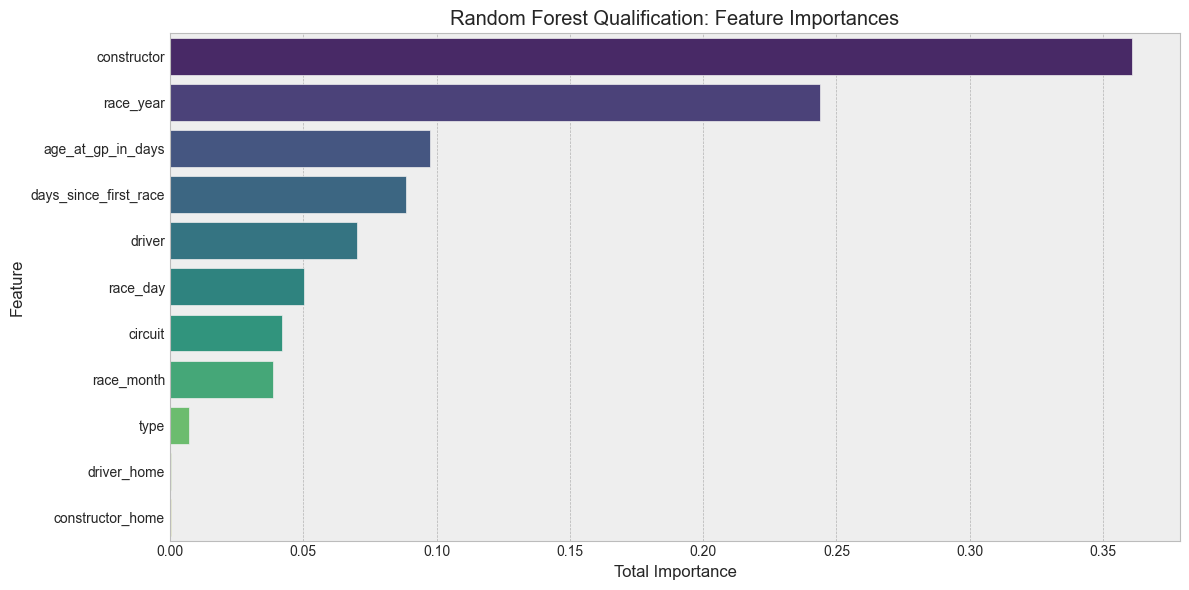

In [26]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name

    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Random Forest Qualification: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [27]:
# save
with open('rf_qualification.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


In [28]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_rf)
print(f"Weighted Position Error Random Forest: {wpe:.2f}")

wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_rf)
print(f"Top 5 Weighted Position Error Random Forest: {wpe5:.2f}")

# Calculate general errors
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Random Forest: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Top 5 Random Forest: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Error Random Forest: 4.05
Top 5 Weighted Position Error Random Forest: 4.58
General Errors Random Forest: MSE: 5.45, RMSE: 2.34, R2: 0.3208, MAE: 1.74
General Errors Top 5 Random Forest: MSE: 4.77, RMSE: 2.19, R2: -1.3810, MAE: 1.62


<h5>Gradient boost regressor</h5>

In [30]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__loss': [ 'huber'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 5, 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }

param_grid = {
    'model__loss': [ 'huber'],
    'model__learning_rate': [ 0.1],
    'model__n_estimators': [ 400],
    'model__min_samples_split': [ 5],
    'model__min_samples_leaf': [ 4],
    'model__max_depth': [5],
}
# Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)


# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 404.73684676065085
Final Model Performance:
MSE: 128388.73
RMSE: 358.31
R2: 0.4991
MAE: 272.86


C:\Users\Linh\AppData\Local\Temp\ipykernel_10244\87544156.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


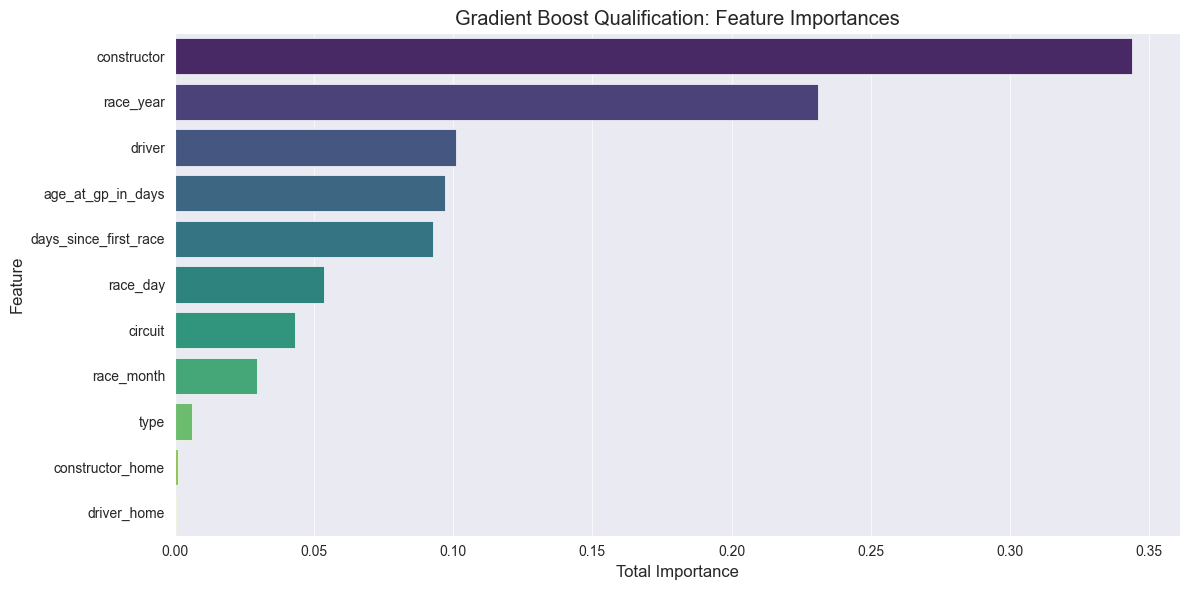

In [31]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name

    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Gradient Boost Qualification: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [32]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_gb)
print(f"Weighted Position Gradient Boost: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_gb)
print(f"Top 5 Weighted Position Error Gradient Boost: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Gradient Boost: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Top 5 Gradient Boost: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Gradient Boost: 3.94
Top 5 Weighted Position Error Gradient Boost: 4.51
General Errors Gradient Boost: MSE: 5.22, RMSE: 2.29, R2: 0.3493, MAE: 1.68
General Errors Top 5 Gradient Boost: MSE: 4.89, RMSE: 2.21, R2: -1.4405, MAE: 1.58


In [33]:
# save
with open('gb_qualification.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>Neural network</h5>

In [42]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100, 100, 100, 100), activation='relu', alpha=0.0001, learning_rate_init=0.001, solver='adam',max_iter=500 , verbose=1))
])

param_grid = {
    'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01],
    'model__solver': ['adam'],
}
# Cross-validation
# k = 5
# cv = KFold(n_splits=k, shuffle=True, random_state=42)
# 
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring='neg_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)

# grid_search.fit(X, y)



# print("Best Parameters:", grid_search.best_params_)
# best_rmse = np.sqrt(-grid_search.best_score_)
# print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

# best_model_nn = grid_search.best_estimator_
best_model_nn = pipeline.fit(X_train, y_train)
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Iteration 1, loss = 158415.91736381
Iteration 2, loss = 157691.04195453
Iteration 3, loss = 157534.84782644
Iteration 4, loss = 157490.10353174
Iteration 5, loss = 157554.48259807
Iteration 6, loss = 157518.79814792
Iteration 7, loss = 157585.58037973
Iteration 8, loss = 157554.40649856
Iteration 9, loss = 157550.07314177
Iteration 10, loss = 157439.14328078
Iteration 11, loss = 157429.33506069
Iteration 12, loss = 157591.56165556
Iteration 13, loss = 157399.86423628
Iteration 14, loss = 157413.17843582
Iteration 15, loss = 157366.58680766
Iteration 16, loss = 157383.58208001
Iteration 17, loss = 157540.60395554
Iteration 18, loss = 157329.86903832
Iteration 19, loss = 157349.77287697
Iteration 20, loss = 157308.15051412
Iteration 21, loss = 157354.15270855
Iteration 22, loss = 157431.98517169
Iteration 23, loss = 157258.57002554
Iteration 24, loss = 156926.10534708
Iteration 25, loss = 156506.85703139
Iteration 26, loss = 155160.13350728
Iteration 27, loss = 153353.48140432
Iteration 

In [43]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_nn)
print(f"Weighted Position Neural Network: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_nn)
print(f"Top 5 Weighted Position Error Neural Network: {wpe5:.2f}")

mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Gradient  Neural Network: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")

mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Top 5 Neural Network: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Neural Network: 4.82
Top 5 Weighted Position Error Neural Network: 5.54
General Errors Gradient  Neural Network: MSE: 7.64, RMSE: 2.76, R2: 0.0487, MAE: 2.07
General Errors Top 5 Neural Network: MSE: 7.06, RMSE: 2.66, R2: -2.5199, MAE: 1.98


In [48]:
# save
with open('nn_qualification.pkl','wb') as f:
    pickle.dump(best_model_nn,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>LightGBM</h5>

In [45]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', LGBMRegressor(random_state=42))
])

# param_grid = {
#     'model__n_estimators': [100, 200, 500],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [5, 10, 20, -1],  
#     'model__num_leaves': [20, 31, 50, 100],
#     'model__min_child_samples': [5, 10, 20, 30]
# }

param_grid = {
    'model__n_estimators': [500],
    'model__learning_rate': [0.05],
    'model__max_depth': [-1],  
    'model__num_leaves': [100],
    'model__min_child_samples': [20]
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_lgbm = grid_search.best_estimator_
y_pred = best_model_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 2894, number of used features: 145
[LightGBM] [Info] Start training from score -38.731168
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
Best RMSE: 409.1546338241012
Final Model Performance:
MSE: 149832.44
RMSE: 387.08
R2: 0.4154
MAE: 298.67


In [46]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Weighted Position LightGBM: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Top 5 Weighted Position Error LightGBM: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Gradient  LightGBM: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Top 5 LightGBM: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position LightGBM: 4.25
Top 5 Weighted Position Error LightGBM: 4.86
General Errors Gradient  LightGBM: MSE: 5.98, RMSE: 2.44, R2: 0.2557, MAE: 1.83
General Errors Top 5 LightGBM: MSE: 5.47, RMSE: 2.34, R2: -1.7262, MAE: 1.74


In [47]:
# save
with open('lgbm_qualification.pkl','wb') as f:
    pickle.dump(best_model_lgbm,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)